# Trained RNNs reproduce human data

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Wedge, Ellipse
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.stats import pearsonr, spearmanr, wilcoxon
from statsmodels.stats.weightstats import DescrStatsW

from dynamic_bias import utils
from dynamic_bias.analyses.behavior import StimulusSpecificBias
from dynamic_bias.analyses.behavior import NearReferenceStatistics
utils.setup_matplotlib()

In [2]:
utils.download_dataset("data/outputs/rnn")

ssb_fits    = utils.load(f'{utils.ORIGIN}/data/outputs/rnn/results_stimulus_specific_bias.pickle')
ssb_weights = utils.load(f'{utils.ORIGIN}/data/outputs/rnn/results_stimulus_specific_bias_weight.pickle')
ssb_boot    = utils.load(f'{utils.ORIGIN}/data/outputs/rnn/bootstrap_stimulus_conditioned.pickle')
ssb_traj    = utils.load(f'{utils.ORIGIN}/data/outputs/rnn/results_stimulus_specific_bias_weight_traj.pickle')

nrvs = utils.load(f'{utils.ORIGIN}/data/outputs/rnn/results_near_reference_variability.pickle')
dcbs = utils.load(f'{utils.ORIGIN}/data/outputs/rnn/results_decision_consistent_bias.pickle')
dcb_funs = utils.load(f'{utils.ORIGIN}/data/outputs/rnn/results_decision_conditioned.pickle')
dcb_boot = utils.load(f'{utils.ORIGIN}/data/outputs/rnn/bootstrap_decision_conditioned.pickle')
dcb_fxpt = utils.load(f'{utils.ORIGIN}/data/outputs/rnn/results_decision_consistent_bias_fixed_points.pickle')
dcb_perm = utils.load(f'{utils.ORIGIN}/data/outputs/rnn/permutation_decision_consistent_bias_fixed_points.pickle')

downloading data/outputs/rnn...
data/outputs/rnn already exists. Skipping download...


---
## Stimulus-specific bias

In [3]:
ssb = StimulusSpecificBias()
id_list   = np.arange(50)
stim_list = utils.exp_stim_list(step=0.75)
evi_list  = np.array([-22.5, -7.5, 0, +7.5, +22.5])

ssb_fun_list = utils.nan((len(id_list),240))
for i_id, v_id in enumerate(id_list): 
    ssb_fun_list[i_id] = ssb(stim_list, ssb_fits[v_id])

ssb_weight = np.array([[w['E'],w['L']] for _,w in ssb_weights.items()])
m_ssb_fun  = np.mean(ssb_fun_list[:,:,np.newaxis]*ssb_weight[:,np.newaxis,:], axis=0)
s_ssb_fun  = np.std(ssb_fun_list[:,:,np.newaxis]*ssb_weight[:,np.newaxis,:], axis=0) / np.sqrt(len(id_list))

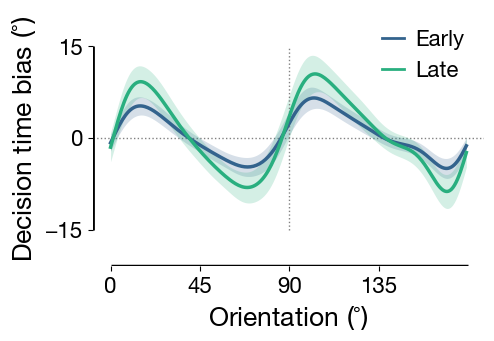

In [4]:
plt.figure()
ax = plt.gca()
utils.set_size([4,2.8])

plt.vlines(x=90, ymin=-15, ymax=15, linestyle='dotted', color='gray', linewidth=1.)
plt.axhline(y=0, linestyle='dotted', color='gray', linewidth=1., zorder=-3)

plt.fill_between(np.arange(180,step=0.75), 
                 m_ssb_fun[:,0]-s_ssb_fun[:,0], 
                 m_ssb_fun[:,0]+s_ssb_fun[:,0], 
                 color=utils.E_COLOR, alpha=0.20, linewidth=0)
plt.fill_between(np.arange(180,step=0.75), 
                 m_ssb_fun[:,1]-s_ssb_fun[:,1], 
                 m_ssb_fun[:,1]+s_ssb_fun[:,1], 
                 color=utils.L_COLOR, alpha=0.20, linewidth=0)

plt.plot(np.arange(180,step=0.75), m_ssb_fun[:,0], color=utils.E_COLOR, linewidth=2.5)
plt.plot(np.arange(180,step=0.75), m_ssb_fun[:,1], color=utils.L_COLOR, linewidth=2.5)
plt.ylim([-21,21])

line_e = mlines.Line2D([], [], color=utils.E_COLOR, label='Early', lw=2)
line_l = mlines.Line2D([], [], color=utils.L_COLOR, label='Late', lw=2)
plt.legend(handles=[line_e, line_l], handlelength=1, 
           frameon=False, loc='upper right', fontsize=16, handletextpad=0.5)

if utils.LABEL:
    plt.xlabel(r"Orientation $(\!\!^\circ\!\!)$")
    plt.ylabel(r"Decision time bias $(\!\!^\circ\!\!)$")

utils.draw_publish_axis(ax, xrange=(0,180), yrange=(-15,15), xticks=[0,45,90,135], yticks=[-15,0,15])
plt.savefig(f'{utils.DIR_FIGURE}/fig6b.pdf', bbox_inches='tight', transparent=True)
plt.show()

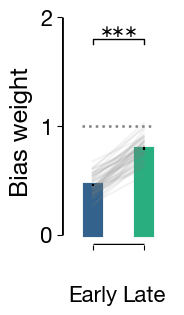

In [5]:
v_E = ssb_weight[:,0]
v_L = ssb_weight[:,1]

ms = [np.mean(v_E), np.mean(v_L)]
ss = [np.std(v_E)/np.sqrt(50), np.std(v_L)/np.sqrt(50)]

plt.figure()
ax = plt.gca()
utils.set_size([1.6,2.6])

xl, xr = -1, 1.5
for i in range(50):
    plt.plot([xl,xr], [v_E[i],v_L[i]], color='gray', alpha=0.09)
    
bar = plt.bar(x=[xl,xr], height=ms, color=[utils.E_COLOR, utils.L_COLOR])
bar[0].set_edgecolor(utils.E_COLOR)
bar[1].set_edgecolor(utils.L_COLOR)
bar[0].set_linewidth(3)
bar[1].set_linewidth(3)
plt.errorbar(x=[xl,xr], y=ms, yerr=ss, fmt="none", color="k")

plt.xlim([xl-1.5,xr+1.5])
plt.ylim([-0.1,2])

ax.hlines(y=1, xmin=xl-0.5, xmax=xr+0.5, linestyle='dotted', color='gray', linewidth=1.8, zorder=-3)

# Add significance asterisks
ax.plot([xl, xl, xr, xr], [1.75, 1.8, 1.8, 1.75], lw=1, c='k')
ax.text((xl+xr)/2., 1.8, r"$ {\ast\!\!\ast\!\!\!\ast} $", ha='center', va='bottom', color='k', fontsize=12)

if utils.LABEL:
    plt.ylabel(r"Bias weight", labelpad=5, fontsize=18)
    plt.tick_params(axis='x', which='major', pad=25)
    plt.xticks([xl,xr], ['Early', 'Late'], fontsize=16)

utils.draw_publish_axis(ax, xrange=(xl,xr), yrange=(0,2), xticks=None, yticks=[0,1,2])
plt.savefig(f'{utils.DIR_FIGURE}/fig6c.pdf', bbox_inches='tight', transparent=True)
plt.show()

In [6]:
ttest  = DescrStatsW(v_L-v_E)
wilcox = wilcoxon(v_L-v_E)
print("Bias weight: Early vs. Late")
print('\nPaired samples t-test')
print('t(49)=',  ttest.ttest_mean()[0], 'p=', ttest.ttest_mean()[1])
print('95% CI=', ttest.tconfint_mean())
print('\nWilcoxon signed-rank test (without continuity correction)')
print('V=', wilcox[0], 'p=', wilcox[1])

Bias weight: Early vs. Late

Paired samples t-test
t(49)= 24.185134040737996 p= 6.781608504398025e-29
95% CI= (0.30520043554210086, 0.36051568077938434)

Wilcoxon signed-rank test (without continuity correction)
V= 0.0 p= 1.7763568394002505e-15


---
## Decision-consistent bias

Decision-consistent bias: Early vs. Late

Paired samples t-test
t(49)= -9.21151982688075 p= 2.859589508950079e-12
95% CI= (-5.22649875557932, -3.354481380294991)

Wilcoxon signed-rank test (without continuity correction)
V= 18.0 p= 4.4941828036826337e-13


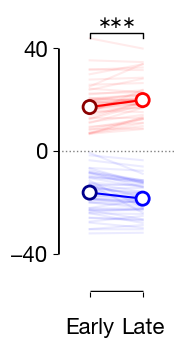

In [7]:
plt.figure()
ax = plt.gca()
utils.set_size([1.6,2.85])

xl, xr = -1, 1.5
v_Ecw  = dcb_funs['combined']['early']['cw']  
v_Eccw = dcb_funs['combined']['early']['ccw'] 
v_Lcw  = dcb_funs['combined']['late'] ['cw']   
v_Lccw = dcb_funs['combined']['late'] ['ccw']  

ms_cw  = [np.median(v_Ecw), np.median(v_Lcw)]
ss_cw  = [np.std(v_Ecw)/np.sqrt(50), np.std(v_Lcw)/np.sqrt(50)]
ms_ccw = [np.median(v_Eccw), np.median(v_Lccw)]
ss_ccw = [np.std(v_Eccw)/np.sqrt(50), np.std(v_Lccw)/np.sqrt(50)]

plt.plot([xl, xr], [ms_cw[0], ms_cw[-1]],   color='red', zorder=0)
plt.plot([xl, xr], [ms_ccw[0], ms_ccw[-1]], color='blue', zorder=0)
plt.axhline(y=0,  linestyle='dotted', color='gray', linewidth=1.)

plt.errorbar(x=[xl], y=ms_cw[0], yerr=ss_cw[0], fmt="none", color="darkred")
plt.errorbar(x=[xr], y=ms_cw[-1], yerr=ss_cw[-1], fmt="none", color="red")
plt.scatter(x=[xl,xr], y=ms_cw, edgecolors=["darkred", "red"], s=90, color='white', zorder=3, lw=2)
for i in range(50):
    plt.plot([xl,xr], [v_Ecw[i],v_Lcw[i]], color='red', alpha=0.08)

plt.errorbar(x=[xl], y=ms_ccw[0], yerr=ss_ccw[0], fmt="none", color="darkblue")
plt.errorbar(x=[xr], y=ms_ccw[-1], yerr=ss_ccw[-1], fmt="none", color="blue")
plt.scatter(x=[xl,xr], y=ms_ccw, edgecolors=["darkblue", "blue"], s=90, color='white', zorder=3, lw=2)
for i in range(50):
    plt.plot([xl,xr], [v_Eccw[i],v_Lccw[i]], color='blue', alpha=0.08)  

plt.xlim([xl-1.5,xr+1.5])
plt.ylim([-55,55])

# Add significance asterisks
plt.plot([xl, xl, xr, xr], [44, 46, 46, 44], lw=1, c='k')
plt.text((xl+xr)/2., 47, r"$ {\ast\!\!\ast\!\!\!\ast} $", ha='center', va='bottom', color='k', fontsize=12)


ttest  = DescrStatsW((v_Lccw-v_Lcw)-(v_Eccw-v_Ecw))
wilcox = wilcoxon((v_Lccw-v_Lcw)-(v_Eccw-v_Ecw))
print("Decision-consistent bias: Early vs. Late")
print('\nPaired samples t-test')
print('t(49)=',  ttest.ttest_mean()[0], 'p=', ttest.ttest_mean()[1])
print('95% CI=', ttest.tconfint_mean())
print('\nWilcoxon signed-rank test (without continuity correction)')
print('V=', wilcox[0], 'p=', wilcox[1])

if utils.LABEL:
    # plt.ylabel(r"Estimation error $(\!\!^\circ\!\!)$")    
    plt.tick_params(axis='x', which='major', pad=15)
    plt.xticks([xl,xr], ['Early', 'Late'], fontsize=16)

utils.draw_publish_axis(ax, xrange=(xl, xr), yrange=(-40,40), xticks=None, yticks=[-40,0,40])
plt.savefig(f'{utils.DIR_FIGURE}/fig6e.pdf', bbox_inches='tight', transparent=True)
plt.show()

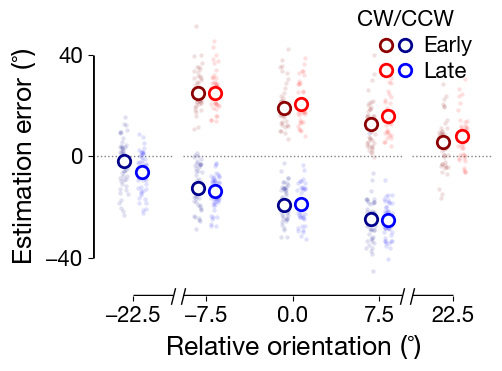

In [8]:
f, ax = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1.1, 3, 1.1]})
plt.subplots_adjust(wspace=0.08)
utils.set_size([4, 2.8])

devi = 0.75 # deviation for scatter plot
for ifig in range(3):
    ax[ifig].axhline(y=0, linestyle='dotted', color='gray', linewidth=1.0)

v_choices = ['cw', 'ccw']
np.random.seed(2023)
for i_evi, v_evi in enumerate( evi_list ):
    ifig = [0, 1, 1, 1, 2][i_evi] # figure index
    ievi = [0, 2, 3, 4, 6][i_evi]

    # early
    v_choices = ['cw', 'ccw']
    for v_delay, v_colors in zip(['early', 'late'], [['darkred', 'darkblue'], ['red', 'blue']]):

        _s = -1 if v_delay == 'early' else +1  # sign for scatter plot

        for v_choice, v_color in zip(v_choices, v_colors):

            if ( (v_evi == -22.5) & (v_choice == 'cw') ) | ( (v_evi ==  22.5) & (v_choice == 'ccw') ):
                continue # lapse omitted for visualization

            _v = dcb_funs['refwise'][v_delay][v_choice][:,ievi]
            _m, _ = utils.meanstats(_v, median=True)
            _j = np.random.uniform(-devi / 2, devi / 2, size=50) # jitter

            ax[ifig].scatter(v_evi + _s*devi,      _m, color='white', edgecolor=v_color, zorder=3, lw=2, s=80)
            ax[ifig].scatter(v_evi + _s*devi + _j, _v, color=v_color, alpha=0.12, linewidth=0, s=10, zorder=0)


d = 4.0  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
                linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax[0].plot(1, 0, transform=ax[0].transAxes, **kwargs)
ax[1].plot(0, 0, transform=ax[1].transAxes, **kwargs)
ax[1].plot(1, 0, transform=ax[1].transAxes, **kwargs)
ax[2].plot(0, 0, transform=ax[2].transAxes, **kwargs)

# 
ost = 2 # offset for broken axis
ax[0].set_xlim([-22.5-ost*1.6,-22.5+ost*1.6])
ax[1].set_xlim([-7.5-ost,7.5+ost])
ax[2].set_xlim([22.5-ost*1.6,22.5+ost*1.6])
for ifig in range(3):
    ax[ifig].set_ylim([-55,55])
    if ifig >= 1 :
        ax[ifig].spines['left'].set_visible(False)
        ax[ifig].set_yticks([])

# legend
from matplotlib.legend_handler import HandlerTuple
markerpar  = {'markeredgewidth': 2, 'markerfacecolor': 'white', 'markersize': 9, 'marker': 'o', 'linestyle': 'None'}
circ_red   = mlines.Line2D([], [], markeredgecolor='red', **markerpar)
circ_blue  = mlines.Line2D([], [], markeredgecolor='blue', **markerpar)
circ_dred  = mlines.Line2D([], [], markeredgecolor='darkred', **markerpar)
circ_dblue = mlines.Line2D([], [], markeredgecolor='darkblue', **markerpar)
plt.legend([(circ_dred,circ_dblue), (circ_red,circ_blue)], ['Early', 'Late'] ,
           handler_map={tuple: HandlerTuple(ndivide=None)},
           frameon=False, loc='upper right', fontsize=16, handletextpad=0.65, handlelength=1.25, labelspacing=0.25)
plt.text(0.73, 0.87, 'CW/CCW', ha='center', va='center', transform=f.transFigure, fontsize=16)


if utils.LABEL:
    ax[0].set_ylabel(r"Estimation error $(\!\!^\circ\!\!)$")    
    ax[1].set_xlabel(r"Relative orientation $(\!\!^\circ\!\!)$")

utils.draw_publish_axis(ax[0], xrange=(-22.5,22.5), yrange=(-40,40), xticks=[-22.5], yticks=[-40,0,40], tight_layout=False)
utils.draw_publish_axis(ax[1], xrange=(-22.5,22.5), yrange=None, xticks=[-7.5,0,7.5], yticks=None, tight_layout=False)
utils.draw_publish_axis(ax[2], xrange=(-22.5,22.5), yrange=None, xticks=[22.5], yticks=None, tight_layout=False)

plt.savefig(f'{utils.DIR_FIGURE}/fig6d.pdf', bbox_inches='tight', transparent=True)
plt.show()

----
### Near-reference variability

In [9]:
evi_list = list(nrvs['refwise']['heterogeneous'].keys())

nrv_het_list = np.array([nrvs['refwise']['heterogeneous'][-v] for v in evi_list])
nrv_het_emonly_list = np.array([nrvs['refwise']['heterogeneous_emonly'][-v] for v in evi_list])

nrv_het_m,  nrv_het_s  = utils.meanstats(nrv_het_list)
nrv_het_em, nrv_het_es = utils.meanstats(nrv_het_emonly_list)

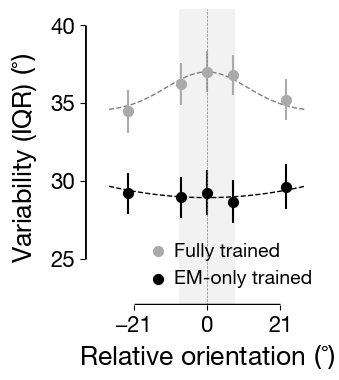

In [10]:
plt.figure()
ax = plt.gca()
utils.set_size([2.8,3.1])

plt.vlines(evi_list, nrv_het_m - nrv_het_s, nrv_het_m + nrv_het_s, color='#AAAAAA', alpha=1)
plt.scatter(evi_list, nrv_het_m, color='#AAAAAA', s=50, zorder=3, label='Fully trained')

plt.vlines(evi_list, nrv_het_em-nrv_het_es, nrv_het_em+nrv_het_es, color='k', alpha=1)
plt.scatter(evi_list, nrv_het_em, color='k', s=50, zorder=3, label='EM-only trained')

nrs = NearReferenceStatistics()
nrs.fit_gaussian(evi_list, nrv_het_list.T, init_params=[0,2,1])
xxx = np.linspace(-28,28,100)
yyy = nrs.centered_gaussian(xxx)
plt.plot(xxx, yyy, color='gray', linestyle='dashed', linewidth=1, zorder=-3)

nrs.fit_gaussian(evi_list, nrv_het_emonly_list.T, init_params=[0,2,1])
xxx = np.linspace(-28,28,100)
yyy = nrs.centered_gaussian(xxx)
plt.plot(xxx, yyy, color='k', linestyle='dashed', linewidth=1, zorder=-3)

plt.axvline(x=0, color='gray', linestyle='dashed', linewidth=0.5)
plt.ylim([22,41])
plt.xlim([-35,35])
plt.legend(frameon=False, handletextpad=-0.2, loc='lower right')
plt.axvspan(-8,8, color='gray', alpha=0.1, zorder=-4, lw=0)

if utils.LABEL:
    ax.set_xlabel(f"Relative orientation $(\!\!^\circ\!\!)$", labelpad=5)
    ax.set_ylabel(f"Variability (IQR) $(\!\!^\circ\!\!)$", labelpad=8)

utils.draw_publish_axis(ax, xrange=(-21,21), yrange=(25,40), xticks=[-21,0,21], yticks=[25,30,35,40])
plt.savefig(f'{utils.DIR_FIGURE}/fig6f.pdf', bbox_inches='tight', transparent=True)
plt.show()

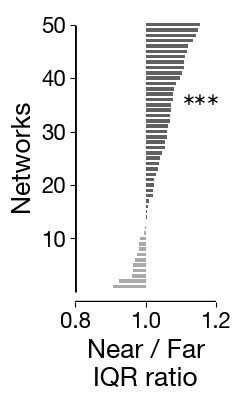

In [11]:
v1 = np.array(nrvs['combined']['heterogeneous']['near'])
v2 = np.array(nrvs['combined']['heterogeneous']['far'])

plt.figure()
ax = plt.gca()
utils.set_size([1.8,2.8])

patches = plt.barh(np.arange(1,51), np.sort(v1/v2)-1, height=0.66, color='k')
for i,p in enumerate(patches):
    if np.sort(v1/v2)[i] > 1:
        plt.setp(p, "facecolor", '#616161')
    else:
        plt.setp(p, "facecolor", '#AAAAAA')
    
ax.set_xlim([-0.2,0.2])
ax.set_xticks([-0.2,0,0.2])
ax.set_xticklabels([0.8,1.,1.2])
ax.set_yticks([10,20,30,40,50])

ax.text(0.1,35, r"$\ast\!\!\ast\!\!\!\ast$", fontsize=12, color='k')
utils.draw_publish_axis(ax, xrange=(-0.3,0.3), yrange=(0,50), xticks=None, yticks=None)
if utils.LABEL:
    plt.xlabel('Near / Far\nIQR ratio')
    plt.ylabel(r'Networks')
plt.savefig(f'{utils.DIR_FIGURE}/fig6g.pdf',bbox_inches='tight',transparent=True)
plt.show()

In [12]:
for v_model, desc_model in zip(['heterogeneous', 'heterogeneous_emonly'], ['(Fully trained)', '(EM-only trained)']):
    v1 = np.array(nrvs['combined'][v_model]['near'])
    v2 = np.array(nrvs['combined'][v_model]['far'])
    ttest  = DescrStatsW(v1/v2 - 1)
    wilcox = wilcoxon(v1/v2 - 1)

    print(f"\n\nNear-reference variability: Near vs. Far {desc_model}")
    print('\nPaired samples t-test')
    print('t(49)=',  ttest.ttest_mean()[0], 'p=', ttest.ttest_mean()[1])
    print('95% CI=', ttest.tconfint_mean())
    print('\nWilcoxon signed-rank test (without continuity correction)')
    print('V=', wilcox[0], 'p=', wilcox[1])



Near-reference variability: Near vs. Far (Fully trained)

Paired samples t-test
t(49)= 5.204606020129456 p= 3.8211339730094605e-06
95% CI= (0.02672564856345458, 0.06034485606540553)

Wilcoxon signed-rank test (without continuity correction)
V= 195.0 p= 6.358623311442102e-06


Near-reference variability: Near vs. Far (EM-only trained)

Paired samples t-test
t(49)= -0.18091494996029628 p= 0.8571805683761023
95% CI= (-0.022035688328006005, 0.018395785734967213)

Wilcoxon signed-rank test (without continuity correction)
V= 567.0 p= 0.5024899674262855


---
## Stimulus specific bias dynamics

In [13]:
ssb_boot['early_err'] = utils.wrap( ssb_boot['early'] - utils.exp_stim_list()[:, None], period=180. )
ssb_boot['late_err']  = utils.wrap( ssb_boot['late']  - utils.exp_stim_list()[:, None], period=180. )

earlym, earlys = utils.meanstats( ssb_boot['early_err'], axis=0, sd=True )
latem,  lates  = utils.meanstats( ssb_boot['late_err'],  axis=0, sd=True )

earlym = utils.wrap(earlym + utils.exp_stim_list()[:, None], period=180.) 
latem  = utils.wrap(latem  + utils.exp_stim_list()[:, None], period=180.)

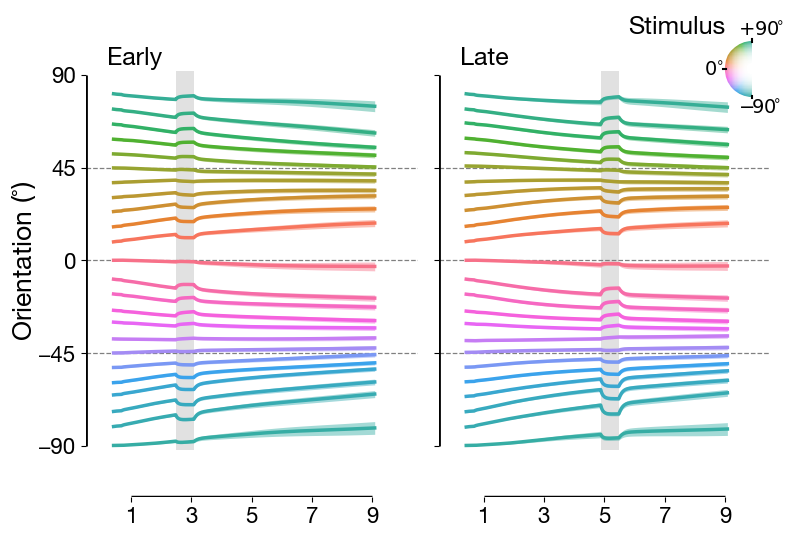

In [14]:
times_el = [(2.5, 3.1), (4.9, 5.5)]
n_timesteps = 455

f, ax = plt.subplots(1,2,sharey=True)
utils.set_size([6,4.2])
ts = np.arange(n_timesteps)*0.02
idx = ts > 0.4

for i, (traj_m, traj_s) in enumerate( zip([earlym, latem], [earlys, lates]) ):
    for s in range(24): 
        ax[i].fill_between(ts[idx], traj_m[s,idx]-traj_s[s,idx], traj_m[s,idx]+traj_s[s,idx], 
                         color=utils.HUSL.colors[s], alpha=0.45, linewidth=0)
        ax[i].plot(ts[idx], traj_m[s,idx], color=utils.HUSL.colors[s], linewidth=2.5)

    ax[i].set_xlim(left=-0.5, right=10.5)
    ax[i].set_ylim([-115,115])
    ax[i].axhline(y=0,   color='gray', linestyle='dashed', linewidth=0.9, zorder=0)
    ax[i].axhline(y=45,  color='gray', linestyle='dashed', linewidth=0.9, zorder=0)
    ax[i].axhline(y=-45, color='gray', linestyle='dashed', linewidth=0.9, zorder=0)
    ax[i].axvspan(*times_el[i], ymin=0.1, ymax=0.9, color='darkgrey', alpha=0.35, linewidth=0, zorder=-3)
    utils.draw_publish_axis(ax[i], xrange=(1,9), yrange=(-90,90), xticks=[1,3,5,7,9], yticks=[-90,-45,0,45,90])

if utils.LABEL:
    ax[0].set_ylabel(r"Orientation $(\!\!^\circ\!\!)$", labelpad=0)
    ax[0].text(0.2,95,'Early',fontsize=18)
    ax[1].text(0.2,95,'Late',fontsize=18)

# Create inset
inset_ax = inset_axes(ax[1], width="25%", height="25%", bbox_to_anchor=(0.10, 0.05, 1, 1), bbox_transform=ax[1].transAxes)
                      
x, y, r = 0, 0, 1
re, im  = np.mgrid[-1:1:100j, -1:1:100j]
dist    = np.clip(np.sqrt(re**2 + im**2)**3, 0, 1)
angle   = np.angle(re + 1j*im)
angle   = np.mod(2.*angle, 2. * np.pi) - np.pi  # Wrap the angle to have two cycles
cmap    = LinearSegmentedColormap.from_list('', utils.HUSL.colors)
img     = plt.pcolormesh(re, im, -angle, shading='auto', cmap=cmap, alpha=dist)

wedge = Wedge(center=(x,y), r=r, theta1=90, theta2=270, width=0.8, clip_on=False, transform=inset_ax.transData)
img.set_clip_path(wedge)
inset_ax.use_sticky_edges = False
inset_ax.margins(x=0.05, y=0.05)
inset_ax.set_xlim([-1.5, 1.5])
inset_ax.set_ylim([-2.1, 2.1])

dd = 0.05
for ang in [np.pi/2., -np.pi/2., np.pi]:
    inset_ax.plot([np.cos(ang)*(1.-dd), np.cos(ang)*(1.+dd)], 
                  [np.sin(ang)*(1.-dd), np.sin(ang)*(1.+dd)], color='k', zorder=3)

ax[1].text(5.8,110, 'Stimulus', size=18)
inset_ax.text(np.cos(np.pi/2.)-0.50,  np.sin(np.pi/2.)+0.15, r'$+90\!\!^\circ$', size=14)
inset_ax.text(np.cos(np.pi)-0.70, np.sin(np.pi)-0.25, r'$\!\!0\!^\circ$', size=14)
inset_ax.text(np.cos(-np.pi/2.)-0.50, np.sin(-np.pi/2.)-0.6, r'$-\!90\!\!^\circ$', size=14)
inset_ax.axis('off')

plt.savefig(f'{utils.DIR_FIGURE}/fig6h.pdf',bbox_inches='tight', transparent=True)
plt.show() 

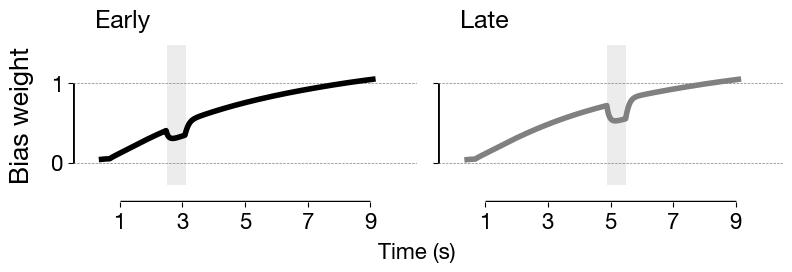

In [15]:
earlym, earlys = utils.meanstats( ssb_traj['early'], axis=0 )
latem,  lates  = utils.meanstats( ssb_traj['late'],  axis=0 )

f, ax = plt.subplots(1,2, sharey=True)
utils.set_size([6,1.9])

for i, (traj_m, traj_s) in enumerate( zip([earlym, latem], [earlys, lates]) ):

    ax[i].axhline(y=0, color='gray', linestyle='dashed', linewidth=0.5)
    ax[i].axhline(y=1, color='gray', linestyle='dashed', linewidth=0.5)
    
    ax[i].plot(ts[idx], traj_m[idx], linewidth=4, color=['k','gray'][i])
    ax[i].fill_between(ts[idx], (traj_m-traj_s)[idx], (traj_m+traj_s)[idx], alpha=0.3, linewidth=0, color=['k','gray'][i])
    ax[i].set_ylim([-0.5,1.7])
    ax[i].set_xlim(left=-0.5, right=10.5)
    ax[i].axvspan(*times_el[i], ymin=0.1, ymax=0.9, color='grey', alpha=0.15, linewidth=0)
    utils.draw_publish_axis(ax[i], xrange=(1,9), yrange=(0,1), xticks=[1,3,5,7,9], yticks=[0,1])

if utils.LABEL:
    ax[0].set_ylabel(r"Bias weight", labelpad=12)
    f.text(0.5,-0.02, r"Time (s)", ha='center', size=16)
    ax[0].text(0.2,1.7,'Early',fontsize=18)
    ax[1].text(0.2,1.7,'Late',fontsize=18)

plt.savefig(f'{utils.DIR_FIGURE}/fig6i.pdf',bbox_inches='tight',transparent=True)
plt.show()

---
## Decision-consistent bias dynamics 

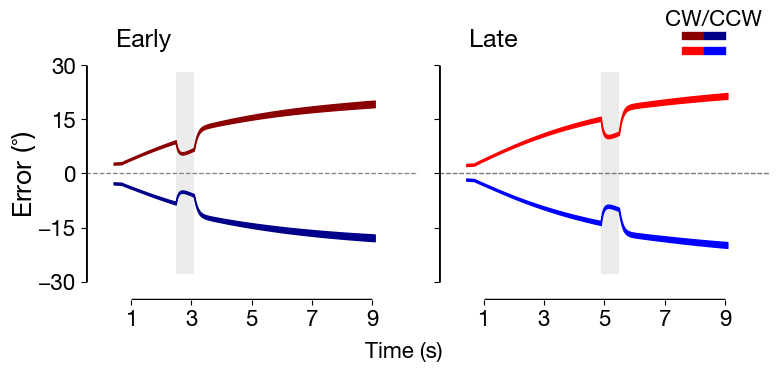

In [16]:
earlym, earlys = utils.meanstats( dcb_boot['early'], axis=0, sd=True, ci=True )
latem,  lates  = utils.meanstats( dcb_boot['late'],  axis=0, sd=True, ci=True )

f, ax = plt.subplots(1,2, sharey=True)
utils.set_size([6,2.5])
plt.axhline(y=0,   color='gray', linestyle='dashed', linewidth=0.9)

for i, (traj_m, traj_s) in enumerate( zip([earlym, latem], [earlys, lates] ) ):
    red  = ['darkred','red'][i]
    blue = ['darkblue','blue'][i]
    
    ax[i].fill_between(ts[idx], traj_m[0,idx]-traj_s[0,idx], traj_m[0,idx]+traj_s[0,idx], color=blue, alpha=1)
    ax[i].fill_between(ts[idx], traj_m[1,idx]-traj_s[1,idx], traj_m[1,idx]+traj_s[1,idx], color=red, alpha=1)
    ax[i].axhline(y=0,   color='gray', linestyle='dashed', linewidth=0.9, zorder=0)
    ax[i].set_ylim([-35,35])
    ax[i].set_xlim(left=-0.5, right=10.5)
    ax[i].axvspan(*times_el[i], ymin=0.1, ymax=0.9, color='grey', alpha=0.15, linewidth=0, zorder=-3)
    utils.draw_publish_axis(ax[i], xrange=(1,9), yrange=(-30,30), xticks=[1,3,5,7,9], yticks=[-30,-15,0,15,30])

# legend
from matplotlib.legend_handler import HandlerTuple
markerpar  = {'markeredgewidth': 2, 'markersize': 9, 'linestyle': '-', 'linewidth': 6}
line_red   = mlines.Line2D([], [], color='red', **markerpar)
line_blue  = mlines.Line2D([], [], color='blue', **markerpar)
line_dred  = mlines.Line2D([], [], color='darkred', **markerpar)
line_dblue = mlines.Line2D([], [], color='darkblue', **markerpar)

plt.legend([(line_dred,line_dblue), (line_red,line_blue)], ['', ''] ,
           handler_map={tuple: HandlerTuple(ndivide=None)},
           frameon=False, loc=(0.72, 0.90), fontsize=16, 
           handletextpad=0.8, handlelength=1.6, labelspacing=-0.22)
plt.text(0.90, 1.02, 'CW/CCW', ha='center', va='center', transform=f.transFigure, fontsize=16)

if utils.LABEL:
    ax[0].text(0.5,35,'Early',fontsize=18)
    ax[1].text(0.5,35,'Late',fontsize=18)
    f.text(0.5,-0.02, r"Time (s)", ha='center', size=16)
    ax[0].set_ylabel(r"Error $(\!\!^\circ\!\!)$", labelpad=0)

plt.savefig(f'{utils.DIR_FIGURE}/fig6j.pdf',bbox_inches='tight', transparent=True)
plt.show()

---
## Assay of biases before and after decision-making

In [17]:
regress_params = {
    k: v for k,v in zip(['c','p','s'], utils.simple_linregress(
        dcbs['d_bpre'], dcbs['d_bpost'],
        return_p_value=True, return_residual_variance=True
    ))
}

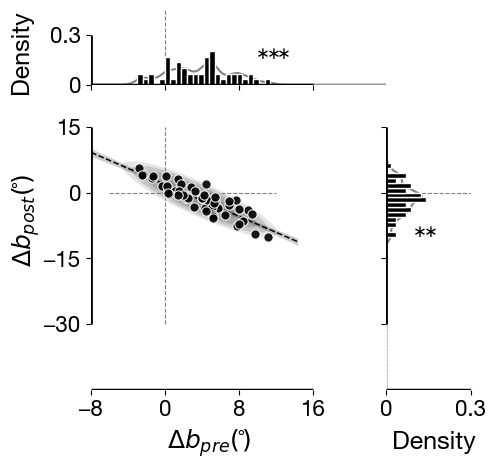

In [18]:
lim = 12
# xlim, ylim = 18, 30
xlim, ylim = 24, 45
f, ax = plt.subplots(2, 2, gridspec_kw={'width_ratios': [3.5, 1], 'height_ratios': [1, 3.5], 'hspace' : 0.25, 'wspace' : 0})

utils.set_size([3.8, 3.8])

# main scatter plot
ax[1,0].vlines(x=0, ymin=-30, ymax=15, linestyle='dashed', color='gray', linewidth=0.8)
ax[1,0].hlines(y=0, xmin=-6,  xmax=12, linestyle='dashed', color='gray', linewidth=0.8)
ax[1,0].scatter(dcbs['d_bpre'], dcbs['d_bpost'], color='k', edgecolor='w', alpha=0.9, s=45, linewidth=0.8, zorder=3)

# plot regression line
x_line = np.linspace(-lim, lim * 1.2, 100)
y_line = regress_params['c']['intercept'] + x_line*regress_params['c']['slope']
s_line = utils.se_line(x_line, dcbs['d_bpre'], regress_params['s'])

ax[1,0].plot(x_line, y_line, color='k', linewidth=1.1, linestyle='dashed')
ax[1,0].fill_between(x_line, y_line - s_line, y_line + s_line, color='k', alpha=0.2, linewidth=0, zorder=-3)

# isoprobability ellipse
for prob, alph in zip( [0.95, 0.9, 0.8, 0.5], [0.2, 0.3, 0.4, 0.5] ):
    pnt, prm = utils.isoprob_ellipse(np.stack([dcbs['d_bpre'], dcbs['d_bpost']]).T, prob=prob)
    ax[1,0].add_patch(Ellipse(**prm, facecolor='gray', zorder=-5, alpha=alph, lw=0))

ax[1,0].set_xlim([-xlim/3, xlim/1])
ax[1,0].set_ylim([-ylim/1, ylim/3])

# d_pre histogram on the top
ax[0,0].axvline(x=0, linestyle='dashed', color='gray', linewidth=0.8, zorder=-3)
ax[0,0].hist(dcbs['d_bpre'], bins=80, range=[-xlim, xlim], color='k', edgecolor='w', 
             orientation='vertical', density=True)
xvals = np.linspace(-xlim, xlim, 1000)
yvals = utils.kde1d(xvals, dcbs['d_bpre'], bw=0.2)
ax[0,0].plot(xvals, yvals, color='gray', zorder=-3)
ax[0,0].set_ylim([0, 0.45])
ax[0,0].set_xlim([-xlim/3, xlim/1])

# d_post histogram on the right
ax[1,1].axhline(y=0, linestyle='dashed', color='gray', linewidth=0.8, zorder=-3)
ax[1,1].hist(dcbs['d_bpost'], bins=80, range=[-ylim, ylim], color='k', edgecolor='w',
             orientation='horizontal', density=True)
xvals = np.linspace(-ylim, ylim, 1000)
yvals = utils.kde1d(xvals, dcbs['d_bpost'], bw=0.25)
ax[1,1].plot(yvals, xvals, color='gray', zorder=-3)
ax[1,1].set_xlim([0, 0.3])
ax[1,1].set_ylim([-ylim/1, ylim/3])

ax[0,0].set_yticks([0,0.3])
ax[0,0].set_yticklabels(['0','0.3'])
ax[0,0].set_xticklabels([])
ax[1,1].set_xticks([0,0.3])
ax[1,1].set_xticklabels(['0','0.3'])
ax[1,1].set_yticklabels([])

utils.draw_publish_axis(ax[0,0], tight_layout=False, xrange=(-8,16), yrange=(0,0.3),  xticks=[-8,0,8,16], yticks=[0,0.3])
utils.draw_publish_axis(ax[1,0], tight_layout=False, xrange=(-8,16), yrange=(-30,15), xticks=[-8,0,8,16], yticks=[-30,-15,0,15])
utils.draw_publish_axis(ax[1,1], tight_layout=False, xrange=(0,0.3), yrange=(-30,15), xticks=[0,0.3],     yticks=[-30,-15,0,15])

# remove the empty top-right subplot
ax[0,1].axis('off')

if utils.LABEL:
    kwargs = dict(fontsize=18, transform=plt.gcf().transFigure)
    plt.text(-0.04,  0.72, 'Density', rotation=90, **kwargs)
    plt.text(-0.04,  0.38, r"$\Delta b_{post}(\!\!^\circ\!\!)$", rotation=90, **kwargs)
    plt.text( 0.28, -0.01, r"$\Delta b_{pre}(\!\!^\circ\!\!)$", **kwargs)
    plt.text( 0.74, -0.01, 'Density', **kwargs)
    
    kwargs = dict(fontsize=12, transform=plt.gcf().transFigure)
    plt.text( 0.46,  0.78, r"$ {\ast\!\!\ast\!\!\!\!\ast} $", **kwargs)
    plt.text( 0.78,  0.42, r"$ {\ast\!\!\ast} $", **kwargs)

plt.savefig(f'{utils.DIR_FIGURE}/fig6k.pdf', bbox_inches='tight', transparent=True)
plt.show()

In [19]:
spear = spearmanr(dcbs['d_bpre'],dcbs['d_bpost'])
pears = pearsonr(dcbs['d_bpre'],dcbs['d_bpost'])
pears_CI = utils.pearson_CI(dcbs['d_bpre'],dcbs['d_bpost'])
print('Behavior : Relation between d_bpre and d_bpost')
print('\nLinear regression')
print(f"Coefficient: {regress_params['c']['slope']}")
print(f"p-value: {regress_params['p']['slope']}")
print('\nCorrelation coefficient')
print('Pearson r=', pears[0], 'p=', pears[1])
print('Pearson CI=', pears_CI)
print('Spearman rho=', spear.correlation, 'p=', spear.pvalue)

print("\nΔb_pre vs. 0")
ttest  = DescrStatsW(dcbs['d_bpre'])
wilcox = wilcoxon(dcbs['d_bpre'])
print('One-sample t-test')
print('t(49)=',  ttest.ttest_mean()[0], 'p=', ttest.ttest_mean()[1])
print('95% CI=', ttest.tconfint_mean())
print('Wilcoxon signed-rank test (without continuity correction)')
print('V=', wilcox[0], 'p=', wilcox[1])

print("\nΔb_post vs. 0")
ttest  = DescrStatsW(dcbs['d_bpost'])
wilcox = wilcoxon(dcbs['d_bpost'])
print('One-sample t-test')
print('t(49)=',  ttest.ttest_mean()[0], 'p=', ttest.ttest_mean()[1])
print('95% CI=', ttest.tconfint_mean())
print('Wilcoxon signed-rank test (without continuity correction)')
print('V=', wilcox[0], 'p=', wilcox[1])

Behavior : Relation between d_bpre and d_bpost

Linear regression
Coefficient: -0.9111245742931684
p-value: 6.482787013984034e-17

Correlation coefficient
Pearson r= -0.8772832480808734 p= 6.482787013984105e-17
Pearson CI= (-0.9288220939716707, -0.7924417031003641)
Spearman rho= -0.8802400960384154 p= 3.737320154988751e-17

Δb_pre vs. 0
One-sample t-test
t(49)= 7.793173611555282 p= 3.9622446849070734e-10
95% CI= (2.803304643646686, 4.75138306103456)
Wilcoxon signed-rank test (without continuity correction)
V= 76.0 p= 9.785132704109856e-10

Δb_post vs. 0
One-sample t-test
t(49)= -3.0731800618494507 p= 0.003454894228492804
95% CI= (-2.5586406456502866, -0.5354148259220952)
Wilcoxon signed-rank test (without continuity correction)
V= 354.0 p= 0.005579489549422334


---
## Assay of biases around fixed points

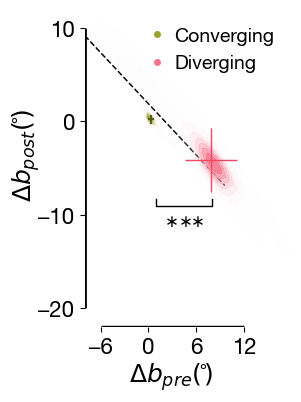

In [20]:
# colors
N_VIS = 500 # number of samples to visualize
cmps = {
    'converging' : utils.interp_colormap(color_u=utils.HUSL.colors[6]+(1,)),
    'diverging'  : utils.interp_colormap(color_u=utils.HUSL.colors[0]+(1,))
}

plt.figure()
ax = plt.gca()
utils.set_size([2.3, 3])

# plot KDE plots for 'converging' and 'diverging'
for i_cond, cond in enumerate(['converging', 'diverging']):
    dbpre_m,  dbpre_s  = utils.meanstats(dcb_fxpt['d_bpre'][cond],  median=True, sd=True)
    dbpost_m, dbpost_s = utils.meanstats(dcb_fxpt['d_bpost'][cond], median=True, sd=True)

    # KDE plot for pre and post
    sns.kdeplot(x=dcb_fxpt['d_bpre'][cond][:N_VIS], y=dcb_fxpt['d_bpost'][cond][:N_VIS],
                cmap=cmps[cond], fill=True, thresh=0.001, levels=9)
    
    if i_cond == 0: lw = 1.5
    else: lw = 1.0
    plt.vlines(dbpre_m, dbpost_m - dbpost_s, dbpost_m + dbpost_s,
               color=utils.lighten_color(cmps[cond].colors[-1], 1.3), linewidth=lw)
    plt.hlines(dbpost_m, dbpre_m - dbpre_s, dbpre_m + dbpre_s,
               color=utils.lighten_color(cmps[cond].colors[-1], 1.3), linewidth=lw)


# Add lines and labels for clarity
xl, xr = 1, 8
plt.plot([xl, xl, xr, xr], [-8.3, -9, -9, -8.3], lw=1, c='k')
plt.text((xl+xr)/2., -11.5, r"${\ast\!\ast\!\!\!\ast}$", ha='center', va='bottom', color='k', fontsize=12)

#
kwargs = dict(marker='o', markersize=4, linestyle='None')
circ1 = mlines.Line2D([], [], color=cmps['converging'](1.0), label='Converging', **kwargs)
circ2 = mlines.Line2D([], [], color=cmps['diverging'](1.0),  label='Diverging', **kwargs)
plt.legend(handles=[circ1, circ2], frameon=False, loc='upper right', fontsize=14, handletextpad=-0.1)

#
lim = 8
x_line = np.linspace(-lim, lim * 1.2, 100)
y_line = regress_params['c']['intercept'] + x_line*regress_params['c']['slope']
plt.plot(x_line, y_line, color='k', linewidth=1.1, zorder=-3, linestyle='dashed')

#
plt.xlim([-8,  18])
plt.ylim([-22, 12])
utils.draw_publish_axis(ax, xrange=(-6,12), yrange=(-20,10), 
                        xticks=[-6,0,6,12], yticks=[-20,-10,0,10])

if utils.LABEL:
    kwargs = dict(fontsize=18, transform=plt.gcf().transFigure)
    plt.text(-0.02,  0.48, r"$\Delta b_{post}(\!\!^\circ\!\!)$", rotation=90, **kwargs)
    plt.text( 0.38, -0.01, r"$\Delta b_{pre}(\!\!^\circ\!\!)$", **kwargs)

plt.savefig(f'{utils.DIR_FIGURE}/fig6l.pdf', bbox_inches='tight', transparent=True)
plt.show()

In [21]:
print("diverging and converging when projected onto the regression line")

# projections on the regression line
proj_obs  = {}
proj_null = {}
for g in ['diverging', 'converging']:
    ## observation
    proj = np.stack([dcb_perm['obs']['d_bpre'][g], dcb_perm['obs']['d_bpost'][g]],axis=-1)
    proj_obs[g] = utils.project(proj, slope=regress_params['c']['slope'])

    ## null
    proj = np.stack([dcb_perm['null']['d_bpre'][g], dcb_perm['null']['d_bpost'][g]],axis=-1)
    proj_null[g] = utils.project(proj, slope=regress_params['c']['slope'])

print("\nProjected Euclidean distance between diverging and converging groups")
dist_obs = proj_obs['diverging'] - proj_obs['converging']
print('Distance:', np.linalg.norm(dist_obs))

print("\nBootstrap test: projected distance between diverging and converging groups (one-sided)")
dist_null = proj_null['diverging'] - proj_null['converging']
print('p-value:', utils.permutation_test(dist_obs[0,0], dist_null[:,0], alternative='greater'))

diverging and converging when projected onto the regression line

Projected Euclidean distance between diverging and converging groups
Distance: 9.19360280392814

Bootstrap test: projected distance between diverging and converging groups (one-sided)
p-value: 0.0002
